# 490 GeoSpatial Data Science Final: Whale Migration: Temperature Analysis
### Gage Doyle
#### 05/17/2024


In [1]:
import numpy as np
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import netCDF4
import h5netcdf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray as rio

In [2]:

# Define the directory containing the files
directory = "C:/Users/gaged/Desktop/SDS 490 Data/Final Project/migration/Temperature/Data/e4"

# Empty xarray dataset to store merged data
merged_1999 = None
merged_2008 = None

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".nc"):  # Check if the file is a netCDF file
        file_path = os.path.join(directory, filename)
        # Load dataset
        dataset = xr.open_dataset(file_path)
        # Extract the time period from the filename
        time_period = filename.split(".")[2]  # Assuming the filename format is "ersst.v4.yyyymm.nc"
        # Merge subsets sequentially for 1999
        if time_period.startswith("1999"):
            if merged_1999 is None:
                merged_1999 = dataset
            else:
                merged_1999 = xr.merge([merged_1999, dataset])
        # Merge subsets sequentially for 2008
        elif time_period.startswith("2008"):
            if merged_2008 is None:
                merged_2008 = dataset
            else:
                merged_2008 = xr.merge([merged_2008, dataset])


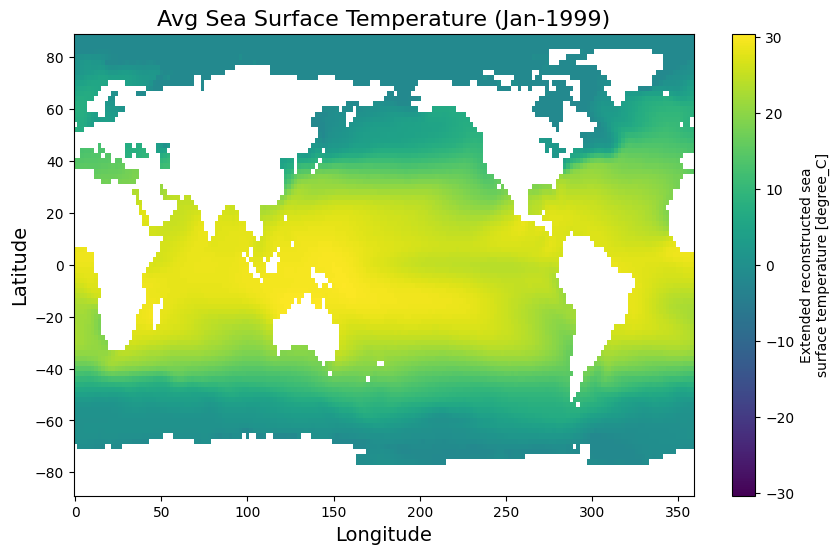

In [3]:
# Plotting merged_1999.sst without clipping and with a preferred style
plt.figure(figsize=(10, 6))
im = merged_1999.sst[0].plot(cmap='viridis')
plt.title('Avg Sea Surface Temperature (Jan-1999)', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.show()

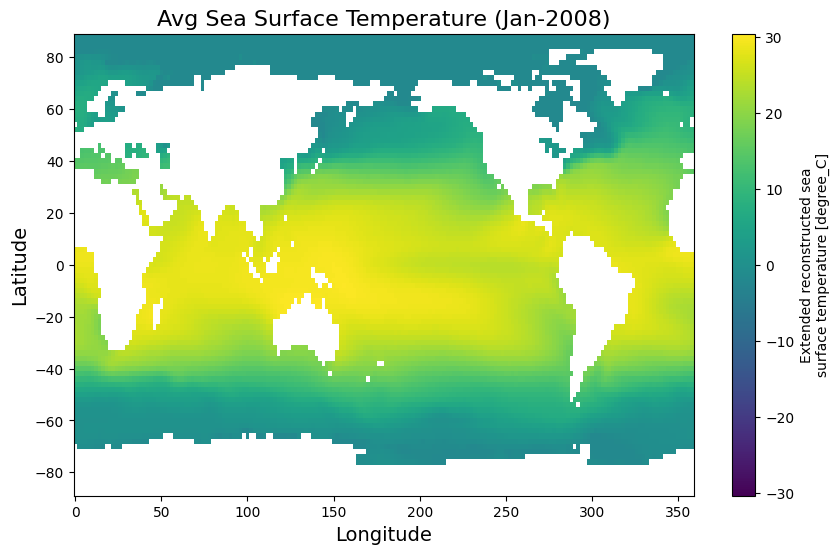

In [4]:
# Plotting merged_1999.sst without clipping and with a preferred style
plt.figure(figsize=(10, 6))
im = merged_1999.sst[0].plot(cmap='viridis')
plt.title('Avg Sea Surface Temperature (Jan-2008)', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.show()

In [5]:
# avg temp for each lat lon for all of '08
avg_sst_1999 = merged_1999.groupby("time.year").mean()

In [6]:
# avg temp for each lat lon for all of '99
avg_sst_2008 = merged_2008.groupby("time.year").mean()

In [7]:
# Reproject to Cal-Coast utm from epsg.io
avg_sst_2008_proj = avg_sst_2008.rio.write_crs("EPSG:3310")

In [8]:
# Reproject to Cal-Coast u from epsg.io
avg_sst_1999_proj = avg_sst_1999.rio.write_crs("EPSG:3310")

In [9]:
#clipped extent
avg_sst_1999_proj = avg_sst_1999_proj.rio.clip_box(minx= 194.338, miny=4.606, maxx=305.638, maxy=53.148)
avg_sst_2008_proj = avg_sst_2008_proj.rio.clip_box(minx= 194.338, miny=4.606, maxx=305.638, maxy=53.148)

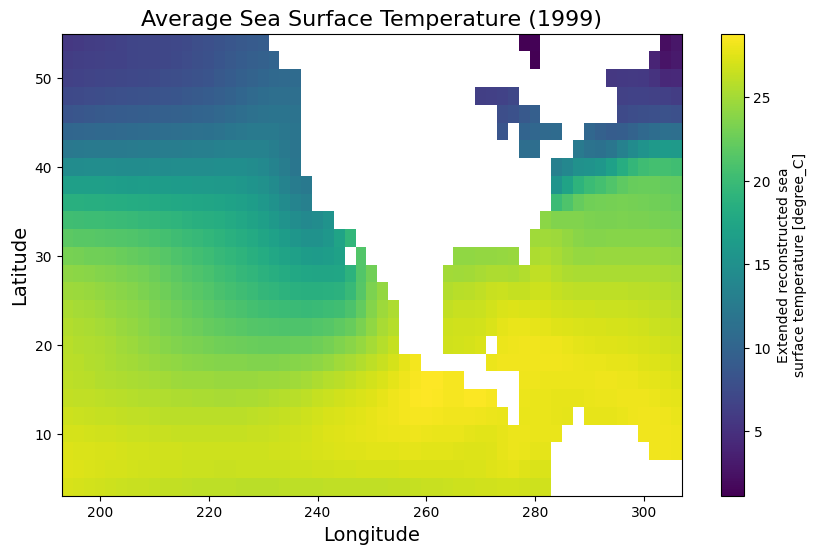

In [10]:
# Plotting avg_sst_1999_proj.sst
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting avg_sst_2008_proj.sst without automatically generating color bar
im = avg_sst_1999_proj.sst.plot(ax=ax, cmap='viridis')

# Set title and axis labels
ax.set_title('Average Sea Surface Temperature (1999)', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.savefig('avg_sst_1999.pdf', bbox_inches='tight')
plt.show()

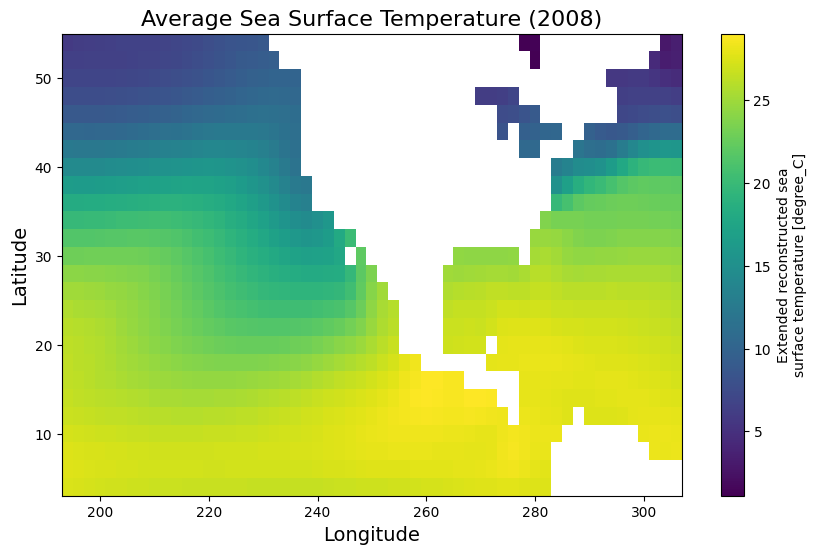

In [11]:
# Plotting avg_sst_2008_proj.sst
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting avg_sst_2008_proj.sst without automatically generating color bar
im = avg_sst_2008_proj.sst.plot(ax=ax, cmap='viridis')

# Set title and axis labels
ax.set_title('Average Sea Surface Temperature (2008)', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.savefig('avg_sst_2008.pdf', bbox_inches='tight')
plt.show()

In [12]:
# Convert to DataFrame with only lat, lon, and sst
df_sst_2008 = avg_sst_2008_proj.sst.to_dataframe().reset_index()[['lat', 'lon', 'sst']]
df_sst_1999 = avg_sst_1999_proj.sst.to_dataframe().reset_index()[['lat', 'lon', 'sst']]


In [13]:
# merge dataframes for change calculations
df_perc_change = pd.merge(df_sst_1999, df_sst_2008, on=['lat','lon'])
df_perc_change = df_perc_change.rename(columns={'sst_x': 'sst_99', 'sst_y': 'sst_08'})

In [14]:
# Change calculations
df_perc_change['change'] = (df_perc_change['sst_08'] - df_perc_change['sst_99'])
df_perc_change['change_percent'] = (((df_perc_change['sst_08'] - df_perc_change['sst_99']) / df_perc_change['sst_99']) * 100)

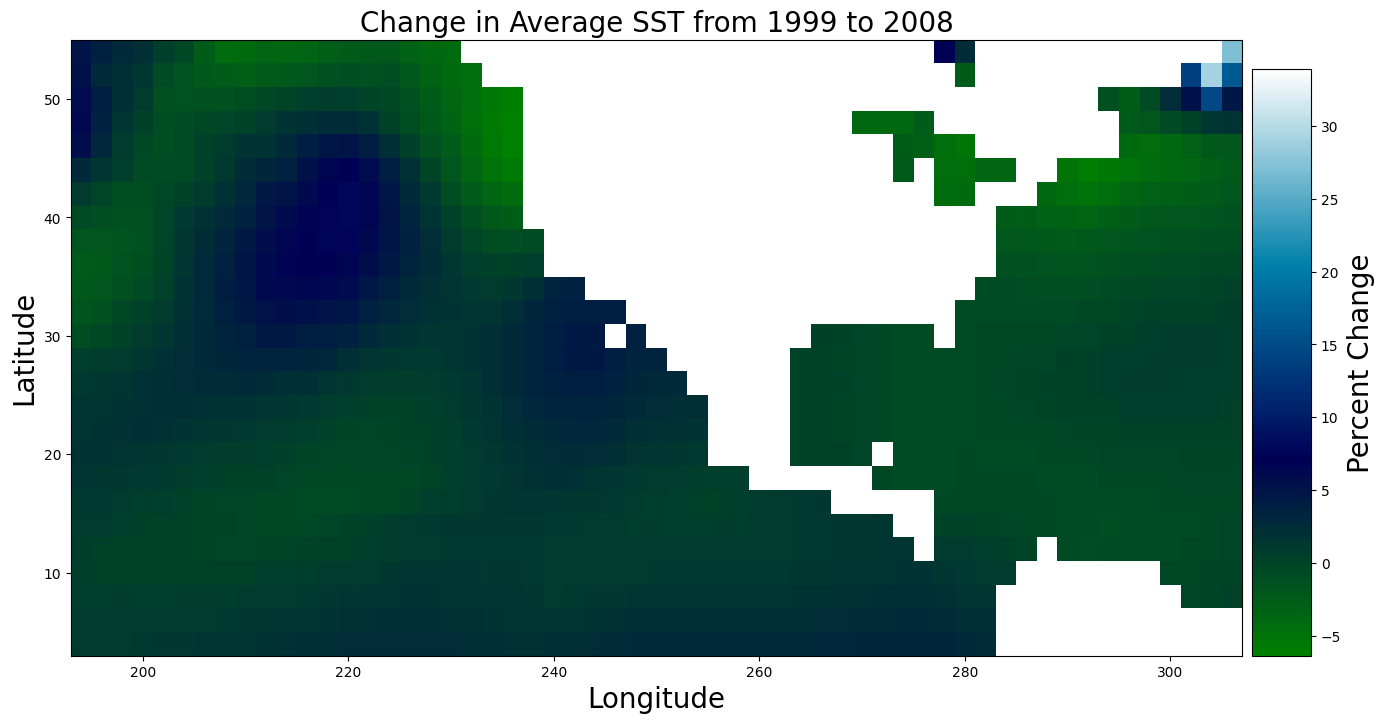

In [15]:
# Convert DataFrame back to an xarray Dataset for plotting
ds_change = df_perc_change.set_index(['lat', 'lon']).to_xarray()
# Plot the SST change
fig, ax = plt.subplots(figsize=(16, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plotting the change in SST
im = ds_change.change_percent.plot(ax=ax, cbar_ax=cax, cmap='ocean', vmin=-6.3718505, vmax=33.911922)
ax.set_title("Change in Average SST from 1999 to 2008",fontsize = 20)
ax.set_ylabel("Latitude", fontsize = 20)
ax.set_xlabel("Longitude",fontsize = 20)

# Set colorbar label
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Percent Change", fontsize = 20)
plt.savefig('change_sst_1999_2008.pdf', bbox_inches='tight')
plt.show()

In [16]:
import geopandas as gpd
from shapely.geometry import Point

# Function to rename columns to fit within 10 character limit
def rename_columns(df):
    rename_dict = {
        'latitude': 'lat',
        'longitude': 'lon',
        'sst': 'sst',
        'change_percent': 'chng_prcnt',
        'change': 'change'
    }
    return df.rename(columns=rename_dict)

# Convert avg_sst_1999_proj to DataFrame
df_sst_1999 = avg_sst_1999_proj.sst.to_dataframe().reset_index()[['lat', 'lon', 'sst']]
df_sst_1999 = rename_columns(df_sst_1999)
df_sst_1999['geometry'] = df_sst_1999.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf_1999 = gpd.GeoDataFrame(df_sst_1999, geometry='geometry')
gdf_1999.set_crs(epsg=3310, inplace=True)
gdf_1999.to_file("avg_sst_1999.shp")

# Convert avg_sst_2008_proj to DataFrame
df_sst_2008 = avg_sst_2008_proj.sst.to_dataframe().reset_index()[['lat', 'lon', 'sst']]
df_sst_2008 = rename_columns(df_sst_2008)
df_sst_2008['geometry'] = df_sst_2008.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf_2008 = gpd.GeoDataFrame(df_sst_2008, geometry='geometry')
gdf_2008.set_crs(epsg=3310, inplace=True)
gdf_2008.to_file("avg_sst_2008.shp")

# Convert ds_change to DataFrame
df_change = ds_change.to_dataframe().reset_index()[['lat', 'lon', 'change', 'change_percent']]
df_change = rename_columns(df_change)
df_change['geometry'] = df_change.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf_change = gpd.GeoDataFrame(df_change, geometry='geometry')
gdf_change.set_crs(epsg=3310, inplace=True)
gdf_change.to_file("change_sst_1999_2008.shp")
